# Contrastive learning

[![](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ganegroup/workshop_nn/blob/main/15_contrastive_learning.ipynb)

En los métodos de contrastive learning el objetivo de entrenamiento es alentar a todas las instancias de clases similares a que se acerquen infinitesimalmente unas a otras en un espacio de embedding, al mismo tiempo que obligan a las instancias de otras clases a alejarse en el espacio de embedding de salida. 

A diferencia de los autoencoders, la red no posee una parte generativa, el embedding se genera a partir de las etiquetas de los objetos y de la elección apropiada de una función de pérdida. 



## Triplet loss

Triplet loss es un tipo de función de pérdida contrastiva propuesto por primera vez por [Schroff et al. para FaceNet](https://arxiv.org/abs/1503.03832), una red diseñada para el reconocimiento facial. 

Triplet loss fuerza puntos de datos de la misma clase a estar más cerca uno del otro que de un punto de datos de otra clase. La pérdida de triplete agrega contexto a la función de pérdida al considerar simultáneamente tanto ejemplos positivos como negativos desde el mismo punto. 

Para calcular la función de pérdida los datos se organizan en sets de a tres: un ancla, un ejemplo positivo y un ejemplo negativo

<!-- ![Diagrama de la función de pérdida Triplet Loss](images/triplet_loss_scheme.png) -->

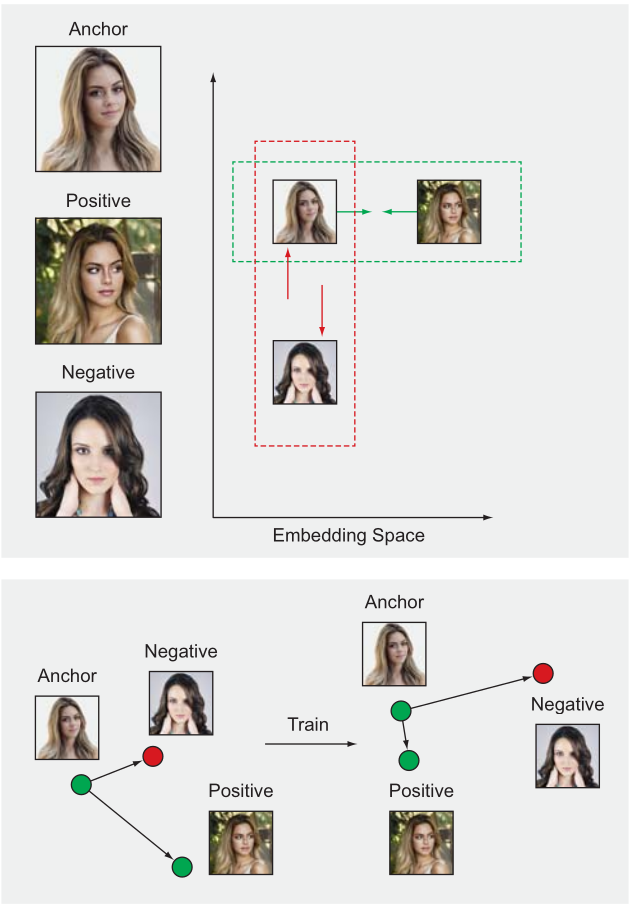

![function](https://user-images.githubusercontent.com/18154355/61484709-7589b800-a96d-11e9-9c3c-e880514af4b7.png)


Hay una implementación de Triplet Loss en la biblioteca `tensorflow_addons`

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

2023-07-02 17:45:31.891801: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
tf.config.list_physical_devices()

2023-07-02 17:45:33.356993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:45:33.360036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:45:33.360151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import io
import numpy as np

In [4]:
(mnist_train_data, mnist_validation_data), mnist_info = tfds.load('mnist', split=["train", "test"], with_info=True, as_supervised=True)

num_classes = 10

# def to_categorical(image, label):
#     return image, tf.one_hot(tf.cast(label, tf.int32), num_classes)

def normalize(image, label):
    """ Normalize image: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def mnist_pipeline(dataset):
    dataset = dataset.map(normalize)
    dataset = dataset.cache()
    return dataset

mnist_train_data = mnist_pipeline(mnist_train_data).shuffle(mnist_info.splits['train'].num_examples)
mnist_validation_data = mnist_pipeline(mnist_validation_data)



2023-07-02 17:45:33.393655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:45:33.393869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:45:33.393995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
batch_size=256
mnist_train_data = mnist_train_data.batch(batch_size)
mnist_validation_data = mnist_validation_data.batch(batch_size)

Vamos a generar una red con una arquitectura como la siguiente:

![fig2](https://user-images.githubusercontent.com/18154355/61485417-1cbb1f00-a96f-11e9-8d6a-94964ce8c4db.png)

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

In [7]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())   #  TripletSemiHardLoss


In [8]:
# Train the network
history = model.fit(
    mnist_train_data,
    epochs=5,
    validation_data=mnist_validation_data
    )

2023-07-02 17:45:34.054503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-07-02 17:45:34.054866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


Epoch 1/5


2023-07-02 17:45:34.514648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'y_pred' with dtype float and shape [?,256]
	 [[{{node y_pred}}]]
2023-07-02 17:45:34.617483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/Max_1_grad/Sum/Max_1/reduction_indices' with dtype int32
	 [[{{node gradients/Max_1_grad/Sum/Max_1/reduction_indices}}]]
2023-07-02 17:45:34.620171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/Min_g

235/235 [==============================] - ETA: 0s - loss: 0.8428

2023-07-02 17:45:40.047212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-07-02 17:45:40.047464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


235/235 [==============================] - 6s 11ms/step - loss: 0.8428 - val_loss: 0.6488
Epoch 2/5
235/235 [==============================] - 2s 10ms/step - loss: 0.7242 - val_loss: 0.5877
Epoch 3/5
235/235 [==============================] - 2s 9ms/step - loss: 0.6793 - val_loss: 0.5547
Epoch 4/5
235/235 [==============================] - 2s 10ms/step - loss: 0.6567 - val_loss: 0.5363
Epoch 5/5
235/235 [==============================] - 2s 9ms/step - loss: 0.6411 - val_loss: 0.5237


In [9]:
# Evaluate the network
results = model.predict(mnist_validation_data)

40/40 [==============================] - 0s 1ms/step


In [10]:
import umap

reducer = umap.UMAP(n_components=2)

reducer.fit(results)

u = reducer.transform(results)

/usr/local/lib/python3.8/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

In [11]:
extract_labels_f = lambda image, label: label
mnist_validation_labels = mnist_validation_data.unbatch().map(extract_labels_f)

labels = tfds.as_numpy(list(mnist_validation_labels))

2023-07-02 17:46:17.236598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-07-02 17:46:17.236853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


<Axes: xlabel='UMAP 1', ylabel='UMAP 2'>

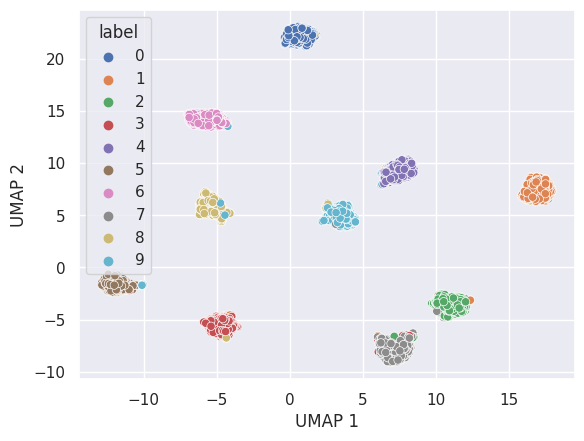

In [12]:
import seaborn as sns
import pandas as pd
sns.set_theme()

data = pd.DataFrame({"UMAP 1": u[:, 0], "UMAP 2": u[:, 1], "label": labels})
data["label"] = data["label"].astype("category")

sns.scatterplot(data=data, x="UMAP 1", y="UMAP 2", hue="label")

Un punto importante a tener en cuenta es que no muchos de los tripletes contribuyen significativamente a la pérdida. En la práctica, durante una época de entrenamiento, la mayoría de los tripletes son triviales: es decir, la red ya tiene poca pérdida en estos, y por lo tanto, los pares positivos de anclaje de estos tripletes triviales están mucho más cerca (en el espacio del embedding) que los pares ancla-negativos. Estos tripletes triviales no aportan información significativa para actualizar los parámetros de la red, lo que retrasa la convergencia. En general hay muchos menos tripletes informativos que tripletes triviales.

Para aumentar la contribución de los tripletes informativos a la red existen técnicas que se conocen como "minado de ejemplos difíciles" que explícitamente priorizan los ejemplos informativos por sobre los triviales.

<!-- ![Clasificación de ejemplos negativos en difíciles, semi-difíciles y fáciles](images/hard_mining.png) -->

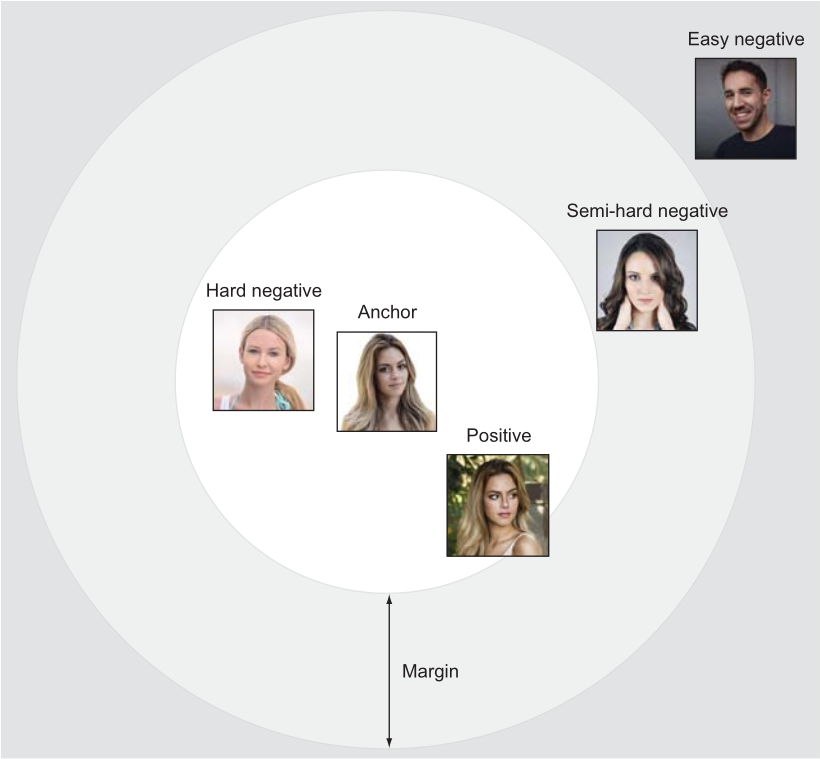

Para hacer el minado se suele clasificar los ejemplos negativos en tres clases:

- Fáciles: El ejemplo negativo está lejos del ancla y lejos del ejemplo positivos
- Semi-difícil: El ejemplo negativo está más lejos del ancla que el ejemplo positivo, pero dentro de cierto margen
- Difícil: El ejemplo negativo está más cerca del ancla que el ejemplo positivo